In [1]:
import pandas as pd
import json

perturbed_bugs = { "Chart-26", "Cli-1" , "Closure-106" , "Codec-1" , 
                  "Collections-25" , "Compress-1" , "Csv-1" , "Gson-1" ,
                  "JacksonCore-1" , "JacksonDatabind-1" , "JacksonXml-1" ,
                  "Jsoup-1" , "JxPath-1" , "Lang-65" , "Math-106" ,
                  "Mockito-28" , "Time-27"
                 }

def read_eval(path):
    df = pd.read_json(path, orient="index")
    df = df[~df.index.isin(perturbed_bugs)]
    return df

In [2]:
def get_number_compile(df):
    count = 0
    all_count = 0
    for index, row in df.iterrows():
        for fix in row.fixes:
            all_count += 1
            if fix["comp_pass"] and row.buggy_line != row.fixed_line:
                count += 1
    return "%d / %d (%.2f%%)" % (count, all_count, count/all_count*100)

In [3]:
def get_number_fixed(df):
    count = 0
    for index, row in df.iterrows():
        for i, fix in enumerate(row.fixes):
            if fix["test_pass"] and row.buggy_line != row.fixed_line:
                count += 1
                break
    return "%d / %d (%.2f%%)" % (count, len(df), count/len(df)*100)

In [4]:
def get_fixed(df):
    result = []
    for index, row in df.iterrows():
        for i, fix in enumerate(row.fixes):
            if fix["test_pass"] and row.buggy_line != row.fixed_line:
                result += [index]
    return result

In [5]:
def get_table_entry(beam_width, critic, round_, tbb, tbs, tdb, tds, cb, tb, cd, td):
    return {"Hyper Parameters": {
                "" :   { "Beam Width" : beam_width }
            },
            "Training": {
                "Bears" : {"BugLab" : tbb, "SelfAPR": tbs},
                "Defects4J" : {"BugLab" : tdb, "SelfAPR": tds},
                "Critic" : { "" : critic },
                "Round" : { "" : round_ }
            },
            "Testing":{
                "Bears Compile" : { "" : cb },
                "Bears Test Pass" : { "" : tb },
                "Defects4J Compile" : { "" : cd},
                "Defects4J Tests Pass" : { "" : td},
            }
       }

Fixed by SelfAPR only: {'Closure-113', 'Cli-28', 'Lang-43', 'Closure-102', 'JacksonDatabind-46', 'Closure-118', 'Compress-14', ' Closure-11', 'Math-22', 'Math-5', 'JacksonDatabind-57', 'Lang-57', 'Compress-33', 'Cli-5', 'Csv-9', 'Closure-104', 'JacksonDatabind-76', 'Chart-8', 'Compress-30', 'Cli-27', 'Math-72', 'Math-104', 'Jsoup-43', 'Jsoup-62', 'Lang-21', 'Lang-33', 'Compress-19', 'Lang-8', 'Csv-11', 'Closure-168', 'Closure-46', 'Math-49', 'Closure-126', 'Closure-13', 'Codec-2', ' Jsoup-47', 'Closure-18', 'Compress-27', 'Chart-4', 'Chart-9', 'Math-75', 'Jsoup-41', 'Closure-57', 'Jsoup-24', 'Chart-14', ' Jsoup-49', 'Cli-18', 'JxPath-10', ' Math-41', 'Closure-6', 'Collections-26', 'Math-80', 'Chart-7', 'Math-79', 'JacksonCore-19', 'Chart-20', 'Math-70', 'Closure-38', 'Cli-25', 'Lang-10', 'Compress-4', 'JacksonDatabind-17', 'Math-32', 'Mockito-5', 'Lang-26', 'JacksonDatabind-27', 'Closure-40', 'Closure-30', 'Lang-4', 'Jsoup-85', 'Math-57', 'Mockito-29', 'Gson-6', 'Compress-31', 'Closure

,Perturb Actions,Repair Actions,No. bugs,Repaired Bugs,Intersection,Intersection Repaired Bugs
0,P1 Replace type,Replace type,3,"Math-30,Math-79,Math-57",0,{}
1,P2 Replace operator,Replace operator,11,"Chart-1,Closure-62,Closure-73,Compress-19,Jack...",7,"{Math-85, JacksonCore-25, Time-19, Closure-73,..."
2,P3 replace literal,Replace literal,14,"Closure-168,Closure-70,Closure-86,Codec-7,Coll...",4,"{Closure-86, Codec-7, Codec-3, Closure-70}"
3,P4 replace constructor,replace constructor,1,Lang-26,0,{}
4,P5 replace variable,Replace variable,14,"Chart-11,Chart-20,Chart-7,Chart-8,Time-4,Jacks...",4,"{Lang-59, Lang-6, Chart-24, Chart-11}"
5,P6 replace condition expression,Replace condition expression,16,"Closure-113,Closure-18,Closure-57,Mockito-29,M...",0,{}
6,P7 replace invocation,replace invocation,11,"Closure-30,Closure-92,Codec-17,Lang-4,Math-75,...",1,{Codec-17}
7,P8 compound statement,compound statement,3,"Cli-18, Math-41,Mockito-11",0,{}
8,P9 replace with similarity,replace with similarity,5,"Mockito-5,Cli-28,Jsoup-41,Jsoup-85,Csv-11",0,{}
9,P10 move statement,move statement,2,"Closure-13, Jsoup-49",0,{}


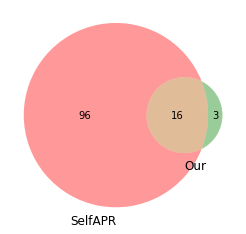

In [6]:
#Import libraries
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib import pyplot as plt

def compare_selfapr(selfapr_path, path):
    our_df = read_eval(path)
    our_fixed = set(get_fixed(our_df))
    selfapr_df = pd.read_csv(selfapr_path, delimiter=';')
    selfapr_fixed = set()
    
    intersection = []
    intersection_list = []
    for index, row in selfapr_df.iterrows():
        new_selfapr_fixes = set(filter(lambda x: x != "", row["Repaired Bugs"].split(",")))
        inter = new_selfapr_fixes.intersection(our_fixed)
        intersection += [len(inter)]
        intersection_list += [inter]
        selfapr_fixed.update(new_selfapr_fixes)
    selfapr_df["Intersection"] = intersection
    selfapr_df["Intersection Repaired Bugs"] = intersection_list
    
    venn2([selfapr_fixed, our_fixed], ("SelfAPR", "Our"))
    print("Fixed by SelfAPR only: " + str(selfapr_fixed - our_fixed))
    print("Fixed by both: " + str(selfapr_fixed.intersection(our_fixed)))
    print("Fixed by us only: " + str(our_fixed - selfapr_fixed))
    return selfapr_df

compare_selfapr("selfapr_fixed.csv", "experiments/defects4j_buglab/round1-compiler/part2/fixer/eval_defects4j_bw_100.json")

In [7]:
entries = []

path = "experiments/defects4j_selfapr/round0/fixer/eval_defects4j_bw_100.json"
cb = "N/A"
tb = "N/A"
cd = get_number_compile(read_eval(path))
td = get_number_fixed(read_eval(path))
entries += [get_table_entry(100, "", "round0", "", "", "", "x", cb, tb, cd, td)]

path = "experiments/defects4j_buglab/round0/fixer/eval_defects4j_bw_100.json"
cb = "N/A"
tb = "N/A"
cd = get_number_compile(read_eval(path))
td = get_number_fixed(read_eval(path))
entries += [get_table_entry(100, "", "round0", "", "", "x", "", cb, tb, cd, td)]

path = "experiments/defects4j_buglab/round1-nocritic/part2/fixer/eval_defects4j_bw_100.json"
cb = "N/A"
tb = "N/A"
cd = get_number_compile(read_eval(path))
td = get_number_fixed(read_eval(path))
entries += [get_table_entry(100, "nocritic", "round1", "", "", "x", "", cb, tb, cd, td)]

path = "experiments/defects4j_buglab/round2-nocritic/part2/fixer/eval_defects4j_bw_100.json"
cb = "N/A"
tb = "N/A"
cd = get_number_compile(read_eval(path))
td = get_number_fixed(read_eval(path))
entries += [get_table_entry(100, "nocritic", "round2", "", "", "x", "", cb, tb, cd, td)]

path = "experiments/defects4j_buglab/round1-compiler/part2/fixer/eval_defects4j_bw_100.json"
cb = "N/A"
tb = "N/A"
cd = get_number_compile(read_eval(path))
td = get_number_fixed(read_eval(path))
entries += [get_table_entry(100, "compiler", "round1", "", "", "x", "", cb, tb, cd, td)]

ValueError: Expected object or value

In [ ]:
table = pd.json_normalize(data=entries)
table.columns = table.columns.str.split(".").map(tuple)
table